사용 중인 디바이스: cuda
모델 파일 없음. 새로 학습 시작.


PPO 학습 진행률:   0%|          | 0/1000 [00:00<?, ?it/s]

PPO 모델이 'C:\baramproject\trained_model\sibal13\navigation_model_ppo.pth'로 저장되었습니다.


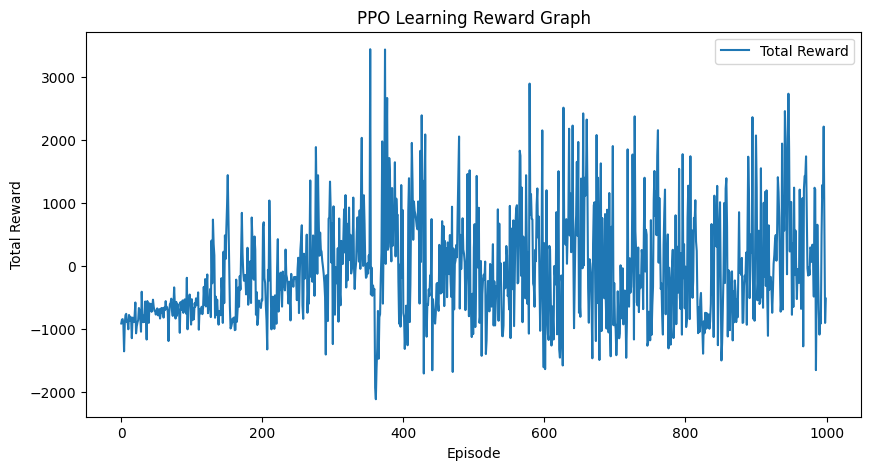

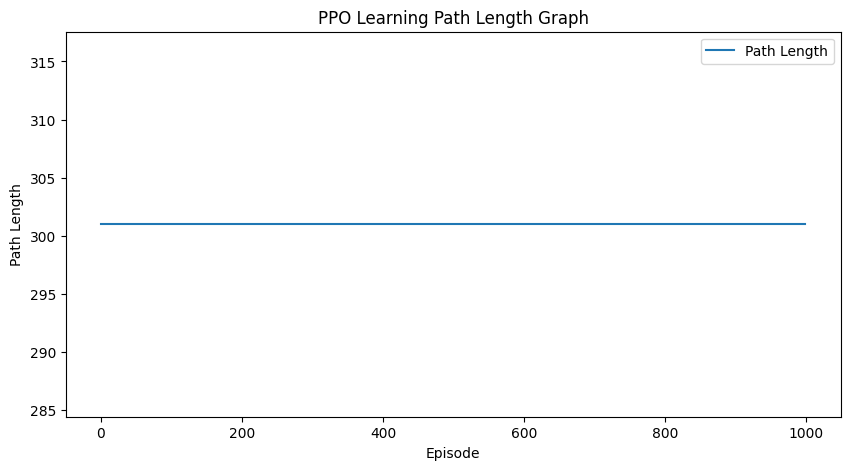

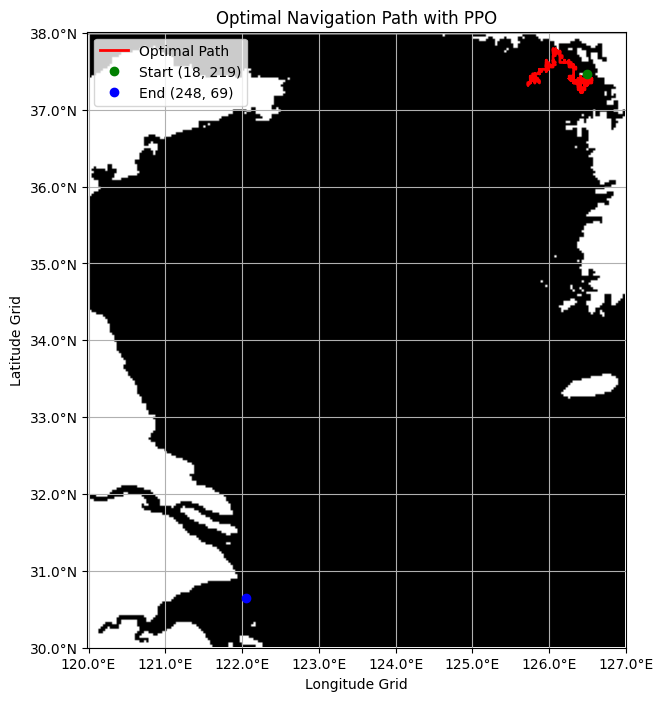

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import math
import json
from datetime import datetime, timedelta
import multiprocessing as mp

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# 하이퍼파라미터 설정
HYPERPARAMS = {
    'learning_rate': 0.001,
    'clip_eps': 0.1,
    'gamma': 0.99,
    'epochs': 5,
    'num_episodes': 1000,
    'max_steps': 500,
    'step_time_minutes': 12,
    'reward_scale': 10,
    'goal_reward': 1000,
    'collision_penalty': -10,
    'tidal_bonus': 1.0,
    'tidal_penalty': -0.7,
    'num_envs': 1  # 병렬 환경 수 (GPU 성능에 따라 조정 가능)
}

# 그리드 로드 및 설정
grid = np.load(r'C:/baramproject/sibal/land_sea_grid_cartopy_downsized.npy')
n_rows, n_cols = grid.shape

# 위경도를 그리드 좌표로 변환
def latlon_to_grid(lat, lon, lat_min=30, lat_max=38, lon_min=120, lon_max=127):
    row = int((lat_max - lat) / (lat_max - lat_min) * n_rows)
    col = int((lon - lon_min) / (lon_max - lon_min) * n_cols)
    return min(max(row, 0), n_rows-1), min(max(col, 0), n_cols-1)

# 시작점과 목표점 설정
start_lat, start_lon = 37.46036, 126.52360
end_lat, end_lon = 30.62828, 122.06400
start_pos = latlon_to_grid(start_lat, start_lon)
end_pos = latlon_to_grid(end_lat, end_lon)

# 유클리드 거리 계산
def euclidean_distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# 조류 데이터 로드
def load_tidal_data(time_str):
    file_path = f"C:/baramproject/tidal_database/tidal_{time_str}.json"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"파일 {file_path}가 존재하지 않습니다.")
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['result']['data']

# 조류 데이터를 그리드에 매핑
def map_tidal_to_grid(tidal_data, n_rows, n_cols):
    current_grid = np.zeros((n_rows, n_cols, 2))
    for entry in tidal_data:
        lat = float(entry['pre_lat'])
        lon = float(entry['pre_lon'])
        row, col = latlon_to_grid(lat, lon)
        if 0 <= row < n_rows and 0 <= col < n_cols and grid[row, col] == 0:
            direction = float(entry['current_dir'])
            speed = float(entry['current_speed'])
            current_grid[row, col] = [direction, speed]
    return current_grid

# 환경 클래스 정의
class NavigationEnv:
    def __init__(self, grid, start_pos, end_pos, tidal_database_path):
        self.grid = grid
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.current_pos = start_pos
        self.actions = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]
        self.visit_count = {}
        self.prev_action = None
        self.tidal_database_path = tidal_database_path
        self.max_steps = HYPERPARAMS['max_steps']
        self.step_time_minutes = HYPERPARAMS['step_time_minutes']
        self.current_time = None
        self.current_tidal_data = None
        self.cumulative_time = 0

    def reset(self, start_time=None):
        if start_time is None:
            start_time = self._random_start_time()
        self.current_pos = self.start_pos
        self.visit_count = {}
        self.prev_action = None
        self.current_time = start_time
        self.cumulative_time = 0
        tidal_data = load_tidal_data(self.current_time.strftime("%Y%m%d_%H%M"))
        self.current_tidal_data = map_tidal_to_grid(tidal_data, n_rows, n_cols)
        return self.get_state()

    def _random_start_time(self):
        start_datetime = datetime(2018, 1, 1, 0, 0)
        end_datetime = datetime(2018, 12, 28, 0, 0)
        total_minutes = int((end_datetime - start_datetime).total_seconds() / 60)
        random_minutes = random.randint(0, total_minutes // 30) * 30
        return start_datetime + timedelta(minutes=random_minutes)

    def get_state(self):
        dx = (self.end_pos[0] - self.current_pos[0]) / n_rows
        dy = (self.end_pos[1] - self.current_pos[1]) / n_cols
        angle_to_goal = math.atan2(dy, dx) if (dx, dy) != (0, 0) else 0
        prev_action_idx = self.actions.index(self.prev_action) if self.prev_action else -1
        row, col = self.current_pos

        if 0 <= row < n_rows and 0 <= col < n_cols:
            current_dir = self.current_tidal_data[row, col, 0] * math.pi / 180
            current_speed = self.current_tidal_data[row, col, 1]
        else:
            current_dir, current_speed = 0, 0

        surrounding_tidal_dirs = []
        surrounding_tidal_speeds = []
        for move in self.actions:
            new_row, new_col = row + move[0], col + move[1]
            if 0 <= new_row < n_rows and 0 <= new_col < n_cols and self.grid[new_row, new_col] == 0:
                tidal_dir = self.current_tidal_data[new_row, new_col, 0] * math.pi / 180
                tidal_speed = self.current_tidal_data[new_row, new_col, 1]
            else:
                tidal_dir, tidal_speed = 0, 0
            surrounding_tidal_dirs.append(tidal_dir)
            surrounding_tidal_speeds.append(tidal_speed)

        state = (
            dx, dy, angle_to_goal, prev_action_idx, current_dir, current_speed,
            *surrounding_tidal_dirs, *surrounding_tidal_speeds
        )
        return state

    def step(self, action):
        move = self.actions[action]
        new_pos = (self.current_pos[0] + move[0], self.current_pos[1] + move[1])

        if (0 <= new_pos[0] < n_rows and 0 <= new_pos[1] < n_cols and self.grid[new_pos] == 0):
            self.current_pos = new_pos
            new_dist = euclidean_distance(self.current_pos, self.end_pos)

            reward = -new_dist / 100
            row, col = self.current_pos
            current_dir = self.current_tidal_data[row, col, 0] * math.pi / 180
            current_speed = self.current_tidal_data[row, col, 1]
            move_angle = math.atan2(move[1], move[0])
            angle_diff = abs((current_dir - move_angle + math.pi) % (2 * math.pi) - math.pi)
            if angle_diff < math.pi / 4:
                reward += current_speed * HYPERPARAMS['tidal_bonus']
            elif angle_diff > 3 * math.pi / 4:
                reward += current_speed * HYPERPARAMS['tidal_penalty']

            if new_dist < 2:
                reward += HYPERPARAMS['goal_reward']
                done = True
            else:
                done = False

            self.prev_action = move
            self.cumulative_time += self.step_time_minutes
            if self.cumulative_time >= 30:
                self.current_time += timedelta(minutes=30)
                tidal_data = load_tidal_data(self.current_time.strftime("%Y%m%d_%H%M"))
                self.current_tidal_data = map_tidal_to_grid(tidal_data, n_rows, n_cols)
                self.cumulative_time -= 30
        else:
            reward = HYPERPARAMS['collision_penalty']
            done = False

        return self.get_state(), reward, done

# 병렬 환경 생성 함수
def make_env():
    return NavigationEnv(grid, start_pos, end_pos, tidal_database_path)

# Actor-Critic 모델 정의
class ActorCritic(nn.Module):
    def __init__(self, input_dim=22, action_dim=8):
        super(ActorCritic, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, state):
        base = self.shared(state)
        action_logits = self.actor(base)
        value = self.critic(base)
        return action_logits, value

# PPO 업데이트 함수
def ppo_update(model, optimizer, states, actions, rewards, next_states, dones, old_log_probs):
    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)
    old_log_probs = torch.tensor(old_log_probs, dtype=torch.float32).to(device)

    for _ in range(HYPERPARAMS['epochs']):
        action_logits, values = model(states)
        _, next_values = model(next_states)
        
        values = values.squeeze(-1)
        next_values = next_values.squeeze(-1)
        
        returns = rewards + HYPERPARAMS['gamma'] * next_values * (1 - dones)
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        dist = torch.distributions.Categorical(logits=action_logits)
        new_log_probs = dist.log_prob(actions)
        ratios = torch.exp(new_log_probs - old_log_probs)

        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - HYPERPARAMS['clip_eps'], 1 + HYPERPARAMS['clip_eps']) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = nn.MSELoss()(values, returns)
        entropy = dist.entropy().mean()
        loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 병렬 환경 설정
tidal_database_path = r"C:\baramproject\tidal_database"
num_envs = HYPERPARAMS['num_envs']
envs = [make_env() for _ in range(num_envs)]

# 모델 초기화
model = ActorCritic(input_dim=22, action_dim=8).to(device)

# 모델 로드 또는 새로 학습
model_path = r'C:\baramproject\trained_model\sibal13\navigation_model_ppo.pth'
if os.path.exists(model_path):
    try:
        model.load_state_dict(torch.load(model_path))
        print(f"기존 PPO 모델 '{model_path}'를 불러왔습니다.")
        num_episodes = 300
    except Exception as e:
        print(f"모델 로드 실패: {e}. 새로 학습 시작.")
        num_episodes = HYPERPARAMS['num_episodes']
else:
    print(f"모델 파일 없음. 새로 학습 시작.")
    num_episodes = HYPERPARAMS['num_episodes']

optimizer = optim.Adam(model.parameters(), lr=HYPERPARAMS['learning_rate'])
save_dir = r'C:\baramproject\trained_model\sibal13\episode_debug'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 학습 루프 (병렬 환경 사용)
rewards = []
path_lengths = []
progress_bar = tqdm(range(num_episodes), desc="PPO 학습 진행률")

for episode in progress_bar:
    all_states, all_actions, all_rewards, all_next_states, all_dones, all_log_probs = [], [], [], [], [], []
    total_rewards = [0] * num_envs
    paths = [[env.start_pos] for env in envs]
    states = [env.reset() for env in envs]
    step = 0

    while step < HYPERPARAMS['max_steps']:
        step += 1
        step_states, step_actions, step_rewards, step_next_states, step_dones, step_log_probs = [], [], [], [], [], []

        for i, state in enumerate(states):
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            with torch.no_grad():
                action_logits, _ = model(state_tensor)
                dist = torch.distributions.Categorical(logits=action_logits)
                action = dist.sample()
                log_prob = dist.log_prob(action)

            next_state, reward, done = envs[i].step(action.item())
            total_rewards[i] += reward
            paths[i].append(envs[i].current_pos)

            step_states.append(state)
            step_actions.append(action.item())
            step_rewards.append(reward)
            step_next_states.append(next_state)
            step_dones.append(done)
            step_log_probs.append(log_prob.item())

            if done:
                states[i] = envs[i].reset()
            else:
                states[i] = next_state

        all_states.extend(step_states)
        all_actions.extend(step_actions)
        all_rewards.extend(step_rewards)
        all_next_states.extend(step_next_states)
        all_dones.extend(step_dones)
        all_log_probs.extend(step_log_probs)

    # 배치로 업데이트
    if len(all_states) > 0:
        ppo_update(model, optimizer, all_states, all_actions, all_rewards, all_next_states, all_dones, all_log_probs)

    avg_reward = sum(total_rewards) / num_envs
    avg_path_length = sum(len(p) for p in paths) / num_envs
    rewards.append(avg_reward)
    path_lengths.append(avg_path_length)
    progress_bar.set_postfix({'Reward': avg_reward, 'Path Length': avg_path_length})

    if episode % 100 == 0 and episode > 0:
        plt.figure(figsize=(10, 8))
        plt.imshow(grid, cmap='gray', origin='upper')
        path_rows = [pos[0] for pos in paths[0]]  # 첫 번째 환경의 경로만 시각화
        path_cols = [pos[1] for pos in paths[0]]
        plt.plot(path_cols, path_rows, 'r-', linewidth=2)
        plt.plot(start_pos[1], start_pos[0], 'go')
        plt.plot(end_pos[1], end_pos[0], 'bo')
        plt.title(f"PPO Path at Episode {episode}")
        save_path = os.path.join(save_dir, f"episode_{episode}.png")
        plt.savefig(save_path)
        plt.close()

# 모델 저장
torch.save(model.state_dict(), model_path)
print(f"PPO 모델이 '{model_path}'로 저장되었습니다.")

# 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(rewards, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Learning Reward Graph')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(path_lengths, label='Path Length')
plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.title('PPO Learning Path Length Graph')
plt.legend()
plt.show()

# 최적 경로 시각화
def plot_path(path, start_pos, end_pos, grid):
    path_rows = [pos[0] for pos in path]
    path_cols = [pos[1] for pos in path]
    plt.figure(figsize=(10, 8))
    plt.imshow(grid, cmap='gray', origin='upper')
    plt.plot(path_cols, path_rows, 'r-', linewidth=2, label='Optimal Path')
    plt.plot(start_pos[1], start_pos[0], 'go', label=f'Start {start_pos}')
    plt.plot(end_pos[1], end_pos[0], 'bo', label=f'End {end_pos}')
    lon_ticks = np.linspace(0, n_cols, 8)
    lon_labels = np.linspace(120, 127, 8)
    plt.xticks(lon_ticks, [f"{lon:.1f}°E" for lon in lon_labels])
    lat_ticks = np.linspace(0, n_rows, 9)
    lat_labels = np.linspace(38, 30, 9)
    plt.yticks(lat_ticks, [f"{lat:.1f}°N" for lat in lat_labels])
    plt.xlabel('Longitude Grid')
    plt.ylabel('Latitude Grid')
    plt.title('Optimal Navigation Path with PPO')
    plt.legend()
    plt.grid(True)
    plt.show()

# 첫 번째 환경의 경로 시각화
plot_path(paths[0], start_pos, end_pos, grid)